In [1]:
!pip install cairocffi
!pip install python-igraph

     |████████████████████████████████| 71kB 5.2MB/s 
  Created wheel for cairocffi: filename=cairocffi-1.2.0-cp37-none-any.whl size=89563 sha256=5cd9d9f4b71259631a03ef9af5eab8d3e35b443989a906d455fbd661130f5880
  Stored in directory: /root/.cache/pip/wheels/40/76/48/f1effadceea83b32e7d957dd0f92db4db8b537d7b72b4ef374
Successfully built cairocffi
     |████████████████████████████████| 3.2MB 8.1MB/s 


In [2]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6MB 7.9MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 1.4MB 6.2MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 931kB 6.3MB/s 
Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 389kB 8.0MB/s 
     |████████████████████████████████| 225kB 8.7MB/s 
     |████████████████████████████████| 235kB 47.7MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.7.2-cp37-none-any.whl size=388143 sha256=048efdf93a73c49636663f15d4dab662001066ab43b6a4dc4c067c622a2421b3
  Stored in directory: /root/.cache/pip/wheels/e7/66/5b/ad17ef7f04b7c425dc6930daac160c3747231b0d65f9ac7972
Successfully built torch-geometric


In [3]:
import torch
import os
import enum
import scipy.sparse as sp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
from torch_geometric.utils import add_self_loops

In [4]:
from torch_geometric.datasets import WikiCS
wiki_cs = WikiCS('...')

Processing...
Done!


In [5]:
# Networkx is not precisely made with drawing as its main feature but I experimented with it a bit
class GraphVisualizationTool(enum.Enum):
    NETWORKX = 0,
    IGRAPH = 1

In [6]:
class DatasetType(enum.Enum):
    WIKICS = 0
    CORA = 1

## Dataset: WikiCS

WIKI-CS, a novel dataset derived from Wikipedia for benchmarking Graph Neural Networks. The dataset consists of nodes corresponding to Computer Science articles, with edges based on hyperlinks and 10 classes representing different branches of the field. We use the dataset to evaluate semi-supervised node classification and single-relation link prediction models.
The node features are derived from the text of the corresponding articles. They were calculated as the average of pretrained GloVe word embeddings (Pennington et al., 2014), resulting in 300-dimensional node features.

**Statistics**
-  Classes: 10
-  Nodes: 11,701
-  Edges: 216123
-  Node feature size: 300



**Reference:** [Wiki-CS: A Wikipedia-Based Benchmark for Graph Neural Networks](https://arxiv.org/abs/2007.02901).


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch device:', device)

Torch device: cuda


In [8]:
wiki_cs_num_classes = wiki_cs.num_classes
print('Number of classes:', wiki_cs_num_classes)

Number of classes: 10


In [9]:
wiki_cs_num_features = wiki_cs.num_features
print(wiki_cs.num_features)
print(wiki_cs.num_node_features)
print(wiki_cs.num_edge_features)

300
300
0


In [10]:
wiki_cs_train_mask = wiki_cs[0]['train_mask']
wiki_cs_val_mask = wiki_cs[0]['val_mask']
wiki_cs_test_mask = wiki_cs[0]['test_mask']

In [11]:
wiki_cs_train_mask[:, :1].shape

torch.Size([11701, 1])

### Make a subgraph

In [12]:
wiki_cs_train_indices = torch.nonzero(wiki_cs_train_mask[:, :1], as_tuple=True)[0]
print('Train indices:', torch.unique(wiki_cs_train_indices).shape, wiki_cs_train_indices.dtype)

Train indices: torch.Size([580]) torch.int64


In [13]:
wiki_cs_val_indices = torch.nonzero(wiki_cs_val_mask[:, :1], as_tuple=True)[0]
print('Validation indices:', torch.unique(wiki_cs_val_indices).shape, wiki_cs_val_indices.dtype)

Validation indices: torch.Size([1769]) torch.int64


In [14]:
wiki_cs_test_indices = torch.nonzero(wiki_cs_test_mask, as_tuple=True)[0]
print('Test indices:', torch.unique(wiki_cs_test_indices).shape, wiki_cs_test_indices.dtype)

Test indices: torch.Size([5847]) torch.int64


In [15]:
wiki_cs[0]['y']

tensor([7, 2, 2,  ..., 2, 5, 7])

In [16]:
wiki_cs_node_features = wiki_cs[0]['x']
print('Features:', wiki_cs_node_features.shape, wiki_cs_node_features.dtype)
wiki_cs_f_size = wiki_cs_node_features.shape[1]
print('Node feature size:', wiki_cs_f_size)

Features: torch.Size([11701, 300]) torch.float32
Node feature size: 300


In [17]:
wiki_cs_labels = wiki_cs[0]['y']
print('Labels:', wiki_cs_labels.shape, wiki_cs_labels.dtype)

Labels: torch.Size([11701]) torch.int64


In [18]:
wiki_cs_edge_index = wiki_cs[0]['edge_index']

In [19]:
wiki_cs_edge_index = add_self_loops(wiki_cs_edge_index)[0]

In [20]:
print('Edge index:', wiki_cs_edge_index.shape, wiki_cs_edge_index.dtype)

Edge index: torch.Size([2, 308811]) torch.int64


In [21]:
def check_self_loop(node_id):
  tmp_idx = []
  for i, v in enumerate(wiki_cs_edge_index[0]):
    if v == node_id:
      tmp_idx.append(i)
  print(tmp_idx)
  for idx in tmp_idx:
    if wiki_cs_edge_index[1][idx] == node_id:
      print('Yes, self loop!')

In [22]:
check_self_loop(1)

[9, 10, 297111]
Yes, self loop!


In [23]:
if device.type == 'cuda':
  wiki_cs_node_features = wiki_cs_node_features.to(device)
  wiki_cs_train_indices = wiki_cs_train_indices.to(device)
  wiki_cs_val_indices = wiki_cs_val_indices.to(device)
  wiki_cs_test_indices = wiki_cs_test_indices.to(device)
  wiki_cs_labels = wiki_cs_labels.to(device)
  wiki_cs_edge_index = wiki_cs_edge_index.to(device)

## Data visualization

In [24]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora)
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment its out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree')
    plt.ylabel('# nodes for a given out-degree') 
    plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 5.0))

    plt.grid(True)
    plt.show()

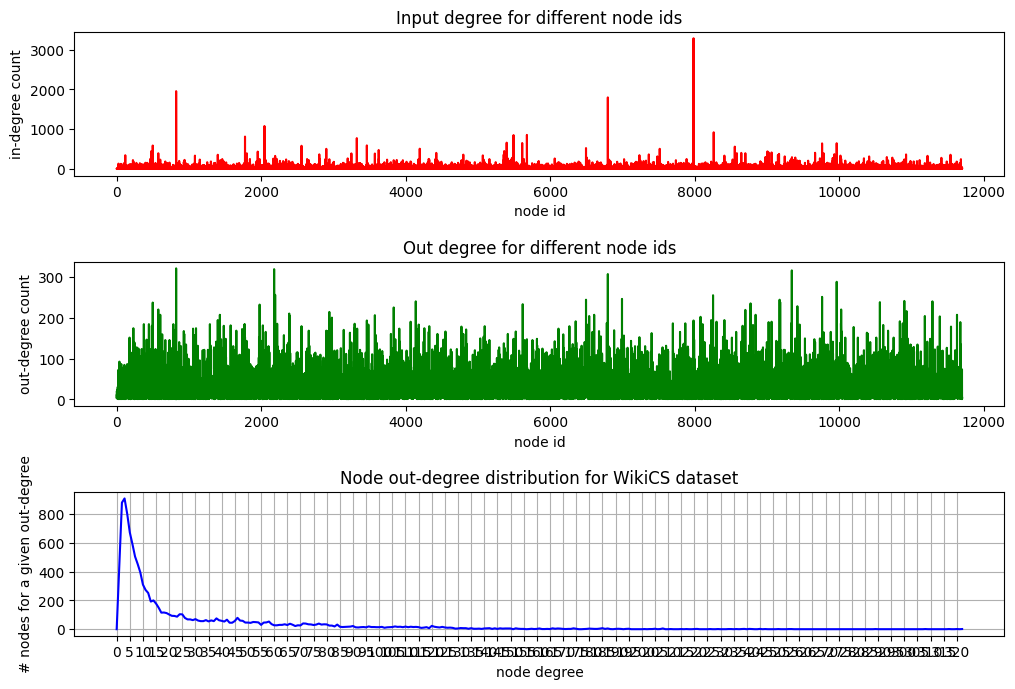

In [25]:
wiki_cs_num_of_nodes = len(wiki_cs_labels)
plot_in_out_degree_distributions(wiki_cs_edge_index, wiki_cs_num_of_nodes, 'WikiCS')

In [26]:
def plot_graph(edge_index, node_labels, dataset_name):
  """
  Check out this blog for available graph visualization tools:
      https://towardsdatascience.com/large-graph-visualization-tools-and-approaches-2b8758a1cd59

  Basically depending on how big your graph is there may be better drawing tools than igraph.

  Note: I unfortunatelly had to flatten this function since igraph is having some problems with Jupyter Notebook,
  we'll only call it here so it's fine!

  """
  
  visualization_tool=GraphVisualizationTool.IGRAPH

  if isinstance(edge_index, torch.Tensor):
      edge_index_np = edge_index.cpu().numpy()

  if isinstance(node_labels, torch.Tensor):
      node_labels_np = node_labels.cpu().numpy()

  num_of_nodes = len(node_labels_np)
  edge_index_tuples = list(zip(edge_index_np[0, :], edge_index_np[1, :]))  # igraph requires this format

  # Construct the igraph graph
  ig_graph = ig.Graph()
  ig_graph.add_vertices(num_of_nodes)
  ig_graph.add_edges(edge_index_tuples)

  # Prepare the visualization settings dictionary
  visual_style = {}

  # Defines the size of the plot and margins
  # go berserk here try (3000, 3000) it looks amazing in Jupyter!!! (you'll have to adjust the vertex_size though!)
  visual_style["bbox"] = (700, 700)
  visual_style["margin"] = 5

  # I've chosen the edge thickness such that it's proportional to the number of shortest paths (geodesics)
  # that go through a certain edge in our graph (edge_betweenness function, a simple ad hoc heuristic)

  # line1: I use log otherwise some edges will be too thick and others not visible at all
  # edge_betweeness returns < 1 for certain edges that's why I use clip as log would be negative for those edges
  # line2: Normalize so that the thickest edge is 1 otherwise edges appear too thick on the chart
  # line3: The idea here is to make the strongest edge stay stronger than others, 6 just worked, don't dwell on it

  edge_weights_raw = np.clip(np.log(np.asarray(ig_graph.edge_betweenness())+1e-16), a_min=0, a_max=None)
  edge_weights_raw_normalized = edge_weights_raw / np.max(edge_weights_raw)
  edge_weights = [w**6 for w in edge_weights_raw_normalized]
  visual_style["edge_width"] = edge_weights

  # A simple heuristic for vertex size. Size ~ (degree / 4) (it gave nice results I tried log and sqrt as well)
  visual_style["vertex_size"] = [deg / 4 for deg in ig_graph.degree()]

  # This is the only part that's Cora specific as Cora has 7 labels
  if dataset_name.lower() == DatasetType.CORA.name.lower():
      visual_style["vertex_color"] = [cora_label_to_color_map[label] for label in node_labels_np]
  else:
      print('Feel free to add custom color scheme for your specific dataset. Using igraph default coloring.')

  # Set the layout - the way the graph is presented on a 2D chart. Graph drawing is a subfield for itself!
  # I used "Kamada Kawai" a force-directed method, this family of methods are based on physical system simulation.
  # (layout_drl also gave nice results for Cora)
  visual_style["layout"] = ig_graph.layout_kamada_kawai()

  print('Plotting results ... (it may take couple of seconds).')
  ig.plot(ig_graph, **visual_style)

  # This website has got some awesome visualizations check it out:
  # http://networkrepository.com/graphvis.php?d=./data/gsm50/labeled/cora.edges

## Graph Attention Network (GAT)

In [27]:
import torch.nn as nn
from torch.optim import Adam


class GAT(torch.nn.Module):
    """
    The most interesting and hardest implementation is implementation #3.
    Imp1 and imp2 differ in subtle details but are basically the same thing.

    So I'll focus on imp #3 in this notebook.

    """

    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, add_skip_connection=True, bias=True,
                 dropout=0.6, log_attention_weights=False):
        super().__init__()
        assert num_of_layers == len(num_heads_per_layer) == len(num_features_per_layer) - 1, f'Enter valid arch params.'

        num_heads_per_layer = [1] + num_heads_per_layer  # trick - so that I can nicely create GAT layers below

        gat_layers = []  # collect GAT layers
        for i in range(num_of_layers):
            layer = GATLayer(
                num_in_features=num_features_per_layer[i] * num_heads_per_layer[i],  # consequence of concatenation
                num_out_features=num_features_per_layer[i+1],
                num_of_heads=num_heads_per_layer[i+1],
                concat=True if i < num_of_layers - 1 else False,  # last GAT layer does mean avg, the others do concat
                activation=nn.ELU() if i < num_of_layers - 1 else None,  # last layer just outputs raw scores
                dropout_prob=dropout,
                add_skip_connection=add_skip_connection,
                bias=bias,
                log_attention_weights=log_attention_weights
            )
            gat_layers.append(layer)

        self.gat_net = nn.Sequential(
            *gat_layers,
        )

    # data is just a (in_nodes_features, edge_index) tuple, I had to do it like this because of the nn.Sequential:
    # https://discuss.pytorch.org/t/forward-takes-2-positional-arguments-but-3-were-given-for-nn-sqeuential-with-linear-layers/65698
    def forward(self, data):
        return self.gat_net(data)

In [28]:
class GATLayer(torch.nn.Module):
    """
    Implementation #3 was inspired by PyTorch Geometric: https://github.com/rusty1s/pytorch_geometric

    But, it's hopefully much more readable! (and of similar performance)

    """
    
    # We'll use these constants in many functions so just extracting them here as member fields
    src_nodes_dim = 0  # position of source nodes in edge index
    trg_nodes_dim = 1  # position of target nodes in edge index

    # These may change in the inductive setting - leaving it like this for now (not future proof)
    nodes_dim = 0      # node dimension (axis is maybe a more familiar term nodes_dim is the position of "N" in tensor)
    head_dim = 1       # attention head dim

    def __init__(self, num_in_features, num_out_features, num_of_heads, concat=True, activation=nn.ELU(),
                 dropout_prob=0.6, add_skip_connection=True, bias=True, log_attention_weights=False):

        super().__init__()

        self.num_of_heads = num_of_heads
        self.num_out_features = num_out_features
        self.concat = concat  # whether we should concatenate or average the attention heads
        self.add_skip_connection = add_skip_connection

        #
        # Trainable weights: linear projection matrix (denoted as "W" in the paper), attention target/source
        # (denoted as "a" in the paper) and bias (not mentioned in the paper but present in the official GAT repo)
        #

        # You can treat this one matrix as num_of_heads independent W matrices
        self.linear_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)

        # After we concatenate target node (node i) and source node (node j) we apply the "additive" scoring function
        # which gives us un-normalized score "e". Here we split the "a" vector - but the semantics remain the same.
        # Basically instead of doing [x, y] (concatenation, x/y are node feature vectors) and dot product with "a"
        # we instead do a dot product between x and "a_left" and y and "a_right" and we sum them up
        self.scoring_fn_target = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))
        self.scoring_fn_source = nn.Parameter(torch.Tensor(1, num_of_heads, num_out_features))

        # Bias is definitely not crucial to GAT - feel free to experiment (I pinged the main author, Petar, on this one)
        if bias and concat:
            self.bias = nn.Parameter(torch.Tensor(num_of_heads * num_out_features))
        elif bias and not concat:
            self.bias = nn.Parameter(torch.Tensor(num_out_features))
        else:
            self.register_parameter('bias', None)

        if add_skip_connection:
            self.skip_proj = nn.Linear(num_in_features, num_of_heads * num_out_features, bias=False)
        else:
            self.register_parameter('skip_proj', None)

        #
        # End of trainable weights
        #

        self.leakyReLU = nn.LeakyReLU(0.2)  # using 0.2 as in the paper, no need to expose every setting
        self.activation = activation
        # Probably not the nicest design but I use the same module in 3 locations, before/after features projection
        # and for attention coefficients. Functionality-wise it's the same as using independent modules.
        self.dropout = nn.Dropout(p=dropout_prob)

        self.log_attention_weights = log_attention_weights  # whether we should log the attention weights
        self.attention_weights = None  # for later visualization purposes, I cache the weights here

        self.init_params()
        
    def forward(self, data):
        #
        # Step 1: Linear Projection + regularization
        #

        in_nodes_features, edge_index = data  # unpack data
        num_of_nodes = in_nodes_features.shape[self.nodes_dim]
        assert edge_index.shape[0] == 2, f'Expected edge index with shape=(2,E) got {edge_index.shape}'

        # shape = (N, FIN) where N - number of nodes in the graph, FIN - number of input features per node
        # We apply the dropout to all of the input node features (as mentioned in the paper)
        # Note: for Cora features are already super sparse so it's questionable how much this actually helps
        in_nodes_features = self.dropout(in_nodes_features)

        # shape = (N, FIN) * (FIN, NH*FOUT) -> (N, NH, FOUT) where NH - number of heads, FOUT - num of output features
        # We project the input node features into NH independent output features (one for each attention head)
        nodes_features_proj = self.linear_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        nodes_features_proj = self.dropout(nodes_features_proj)  # in the official GAT imp they did dropout here as well

        #
        # Step 2: Edge attention calculation
        #

        # Apply the scoring function (* represents element-wise (a.k.a. Hadamard) product)
        # shape = (N, NH, FOUT) * (1, NH, FOUT) -> (N, NH, 1) -> (N, NH) because sum squeezes the last dimension
        # Optimization note: torch.sum() is as performant as .sum() in my experiments
        scores_source = (nodes_features_proj * self.scoring_fn_source).sum(dim=-1)
        scores_target = (nodes_features_proj * self.scoring_fn_target).sum(dim=-1)

        # We simply copy (lift) the scores for source/target nodes based on the edge index. Instead of preparing all
        # the possible combinations of scores we just prepare those that will actually be used and those are defined
        # by the edge index.
        # scores shape = (E, NH), nodes_features_proj_lifted shape = (E, NH, FOUT), E - number of edges in the graph
        scores_source_lifted, scores_target_lifted, nodes_features_proj_lifted = self.lift(scores_source, scores_target, nodes_features_proj, edge_index)
        scores_per_edge = self.leakyReLU(scores_source_lifted + scores_target_lifted)

        # shape = (E, NH, 1)
        attentions_per_edge = self.neighborhood_aware_softmax(scores_per_edge, edge_index[self.trg_nodes_dim], num_of_nodes)
        # Add stochasticity to neighborhood aggregation
        attentions_per_edge = self.dropout(attentions_per_edge)

        #
        # Step 3: Neighborhood aggregation
        #

        # Element-wise (aka Hadamard) product. Operator * does the same thing as torch.mul
        # shape = (E, NH, FOUT) * (E, NH, 1) -> (E, NH, FOUT), 1 gets broadcast into FOUT
        nodes_features_proj_lifted_weighted = nodes_features_proj_lifted * attentions_per_edge

        # This part sums up weighted and projected neighborhood feature vectors for every target node
        # shape = (N, NH, FOUT)
        out_nodes_features = self.aggregate_neighbors(nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes)

        #
        # Step 4: Residual/skip connections, concat and bias
        #

        out_nodes_features = self.skip_concat_bias(attentions_per_edge, in_nodes_features, out_nodes_features)
        return (out_nodes_features, edge_index)

    #
    # Helper functions (without comments there is very little code so don't be scared!)
    #

    def neighborhood_aware_softmax(self, scores_per_edge, trg_index, num_of_nodes):
        """
        As the fn name suggest it does softmax over the neighborhoods. Example: say we have 5 nodes in a graph.
        Two of them 1, 2 are connected to node 3. If we want to calculate the representation for node 3 we should take
        into account feature vectors of 1, 2 and 3 itself. Since we have scores for edges 1-3, 2-3 and 3-3
        in scores_per_edge variable, this function will calculate attention scores like this: 1-3/(1-3+2-3+3-3)
        (where 1-3 is overloaded notation it represents the edge 1-3 and its (exp) score) and similarly for 2-3 and 3-3
         i.e. for this neighborhood we don't care about other edge scores that include nodes 4 and 5.

        Note:
        Subtracting the max value from logits doesn't change the end result but it improves the numerical stability
        and it's a fairly common "trick" used in pretty much every deep learning framework.
        Check out this link for more details:

        https://stats.stackexchange.com/questions/338285/how-does-the-subtraction-of-the-logit-maximum-improve-learning

        """
        # Calculate the numerator. Make logits <= 0 so that e^logit <= 1 (this will improve the numerical stability)
        scores_per_edge = scores_per_edge - scores_per_edge.max()
        exp_scores_per_edge = scores_per_edge.exp()  # softmax

        # Calculate the denominator. shape = (E, NH)
        neigborhood_aware_denominator = self.sum_edge_scores_neighborhood_aware(exp_scores_per_edge, trg_index, num_of_nodes)

        # 1e-16 is theoretically not needed but is only there for numerical stability (avoid div by 0) - due to the
        # possibility of the computer rounding a very small number all the way to 0.
        attentions_per_edge = exp_scores_per_edge / (neigborhood_aware_denominator + 1e-16)

        # shape = (E, NH) -> (E, NH, 1) so that we can do element-wise multiplication with projected node features
        return attentions_per_edge.unsqueeze(-1)

    def sum_edge_scores_neighborhood_aware(self, exp_scores_per_edge, trg_index, num_of_nodes):
        # The shape must be the same as in exp_scores_per_edge (required by scatter_add_) i.e. from E -> (E, NH)
        trg_index_broadcasted = self.explicit_broadcast(trg_index, exp_scores_per_edge)

        # shape = (N, NH), where N is the number of nodes and NH the number of attention heads
        size = list(exp_scores_per_edge.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes
        neighborhood_sums = torch.zeros(size, dtype=exp_scores_per_edge.dtype, device=exp_scores_per_edge.device)

        # position i will contain a sum of exp scores of all the nodes that point to the node i (as dictated by the
        # target index)
        neighborhood_sums.scatter_add_(self.nodes_dim, trg_index_broadcasted, exp_scores_per_edge)

        # Expand again so that we can use it as a softmax denominator. e.g. node i's sum will be copied to
        # all the locations where the source nodes pointed to i (as dictated by the target index)
        # shape = (N, NH) -> (E, NH)
        return neighborhood_sums.index_select(self.nodes_dim, trg_index)

    def aggregate_neighbors(self, nodes_features_proj_lifted_weighted, edge_index, in_nodes_features, num_of_nodes):
        size = list(nodes_features_proj_lifted_weighted.shape)  # convert to list otherwise assignment is not possible
        size[self.nodes_dim] = num_of_nodes  # shape = (N, NH, FOUT)
        out_nodes_features = torch.zeros(size, dtype=in_nodes_features.dtype, device=in_nodes_features.device)

        # shape = (E) -> (E, NH, FOUT)
        trg_index_broadcasted = self.explicit_broadcast(edge_index[self.trg_nodes_dim], nodes_features_proj_lifted_weighted)
        # aggregation step - we accumulate projected, weighted node features for all the attention heads
        # shape = (E, NH, FOUT) -> (N, NH, FOUT)
        out_nodes_features.scatter_add_(self.nodes_dim, trg_index_broadcasted, nodes_features_proj_lifted_weighted)

        return out_nodes_features

    def lift(self, scores_source, scores_target, nodes_features_matrix_proj, edge_index):
        """
        Lifts i.e. duplicates certain vectors depending on the edge index.
        One of the tensor dims goes from N -> E (that's where the "lift" comes from).

        """
        src_nodes_index = edge_index[self.src_nodes_dim]
        trg_nodes_index = edge_index[self.trg_nodes_dim]

        # Using index_select is faster than "normal" indexing (scores_source[src_nodes_index]) in PyTorch!
        scores_source = scores_source.index_select(self.nodes_dim, src_nodes_index)
        scores_target = scores_target.index_select(self.nodes_dim, trg_nodes_index)
        nodes_features_matrix_proj_lifted = nodes_features_matrix_proj.index_select(self.nodes_dim, src_nodes_index)

        return scores_source, scores_target, nodes_features_matrix_proj_lifted

    def explicit_broadcast(self, this, other):
        # Append singleton dimensions until this.dim() == other.dim()
        for _ in range(this.dim(), other.dim()):
            this = this.unsqueeze(-1)

        # Explicitly expand so that shapes are the same
        return this.expand_as(other)

    def init_params(self):
        """
        The reason we're using Glorot (aka Xavier uniform) initialization is because it's a default TF initialization:
            https://stackoverflow.com/questions/37350131/what-is-the-default-variable-initializer-in-tensorflow

        The original repo was developed in TensorFlow (TF) and they used the default initialization.
        Feel free to experiment - there may be better initializations depending on your problem.

        """
        nn.init.xavier_uniform_(self.linear_proj.weight)
        nn.init.xavier_uniform_(self.scoring_fn_target)
        nn.init.xavier_uniform_(self.scoring_fn_source)

        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def skip_concat_bias(self, attention_coefficients, in_nodes_features, out_nodes_features):
        if self.log_attention_weights:  # potentially log for later visualization in playground.py
            self.attention_weights = attention_coefficients

        if self.add_skip_connection:  # add skip or residual connection
            if out_nodes_features.shape[-1] == in_nodes_features.shape[-1]:  # if FIN == FOUT
                # unsqueeze does this: (N, FIN) -> (N, 1, FIN), out features are (N, NH, FOUT) so 1 gets broadcast to NH
                # thus we're basically copying input vectors NH times and adding to processed vectors
                out_nodes_features += in_nodes_features.unsqueeze(1)
            else:
                # FIN != FOUT so we need to project input feature vectors into dimension that can be added to output
                # feature vectors. skip_proj adds lots of additional capacity which may cause overfitting.
                out_nodes_features += self.skip_proj(in_nodes_features).view(-1, self.num_of_heads, self.num_out_features)

        if self.concat:
            # shape = (N, NH, FOUT) -> (N, NH*FOUT)
            out_nodes_features = out_nodes_features.view(-1, self.num_of_heads * self.num_out_features)
        else:
            # shape = (N, NH, FOUT) -> (N, FOUT)
            out_nodes_features = out_nodes_features.mean(dim=self.head_dim)

        if self.bias is not None:
            out_nodes_features += self.bias

        return out_nodes_features if self.activation is None else self.activation(out_nodes_features)

## Training steps

In [29]:
from torch.utils.tensorboard import SummaryWriter


# 3 different model training/eval phases used in train.py
class LoopPhase(enum.Enum):
    TRAIN = 0,
    VAL = 1,
    TEST = 2

    
writer = SummaryWriter()  # (tensorboard) writer will output to ./runs/ directory by default


# Global vars used for early stopping. After some number of epochs (as defined by the patience_period var) without any
# improvement on the validation dataset (measured via accuracy metric), we'll break out from the training loop.
BEST_VAL_ACC = 0
BEST_VAL_LOSS = 0
PATIENCE_CNT = 0

BINARIES_PATH = os.path.join(os.getcwd(), 'models', 'binaries')
CHECKPOINTS_PATH = os.path.join(os.getcwd(), 'models', 'checkpoints')

# Make sure these exist as the rest of the code assumes it
os.makedirs(BINARIES_PATH, exist_ok=True)
os.makedirs(CHECKPOINTS_PATH, exist_ok=True)

In [30]:
# import git
import re  # regex


def get_training_state(training_config, model):
  
    training_state = {
        # "commit_hash": git.Repo(".",search_parent_directories=True).head.object.hexsha,
        
        # Training details
        "dataset_name": training_config['dataset_name'],
        "num_of_epochs": training_config['num_of_epochs'],
        "test_acc": training_config['test_acc'],

        # Model structure
        "num_of_layers": training_config['num_of_layers'],
        "num_heads_per_layer": training_config['num_heads_per_layer'],
        "num_features_per_layer": training_config['num_features_per_layer'],
        "add_skip_connection": training_config['add_skip_connection'],
        "bias": training_config['bias'],
        "dropout": training_config['dropout'],

        # Model state
        "state_dict": model.state_dict()
    }

    return training_state


def print_model_metadata(training_state):
    header = f'\n{"*"*5} Model training metadata: {"*"*5}'
    print(header)

    for key, value in training_state.items():
        if key != 'state_dict':  # don't print state_dict just a bunch of numbers...
            print(f'{key}: {value}')
    print(f'{"*" * len(header)}\n')


# This one makes sure we don't overwrite the valuable model binaries (feel free to ignore - not crucial to GAT method)
def get_available_binary_name():
    prefix = 'gat'

    def valid_binary_name(binary_name):
        # First time you see raw f-string? Don't worry the only trick is to double the brackets.
        pattern = re.compile(rf'{prefix}_[0-9]{{6}}\.pth')
        return re.fullmatch(pattern, binary_name) is not None

    # Just list the existing binaries so that we don't overwrite them but write to a new one
    valid_binary_names = list(filter(valid_binary_name, os.listdir(BINARIES_PATH)))
    if len(valid_binary_names) > 0:
        last_binary_name = sorted(valid_binary_names)[-1]
        new_suffix = int(last_binary_name.split('.')[0][-6:]) + 1  # increment by 1
        return f'{prefix}_{str(new_suffix).zfill(6)}.pth'
    else:
        return f'{prefix}_000000.pth'

In [31]:
import argparse


def get_training_args():
    parser = argparse.ArgumentParser()

    # Training related
    parser.add_argument("--num_of_epochs", type=int, help="number of training epochs", default=10000)
    parser.add_argument("--patience_period", type=int, help="number of epochs with no improvement on val before terminating", default=1000)
    parser.add_argument("--lr", type=float, help="model learning rate", default=1e-3)
    parser.add_argument("--weight_decay", type=float, help="L2 regularization on model weights", default=3e-4)
    parser.add_argument("--should_test", type=bool, help='should test the model on the test dataset?', default=True)

    # Dataset related
    parser.add_argument("--dataset_name", choices=[el.name for el in DatasetType], help='dataset to use for training', default=DatasetType.WIKICS.name)
    parser.add_argument("--should_visualize", type=bool, help='should visualize the dataset?', default=False)

    # Logging/debugging/checkpoint related (helps a lot with experimentation)
    parser.add_argument("--enable_tensorboard", type=bool, help="enable tensorboard logging", default=False)
    parser.add_argument("--console_log_freq", type=int, help="log to output console (epoch) freq (None for no logging)", default=100)
    parser.add_argument("--checkpoint_freq", type=int, help="checkpoint model saving (epoch) freq (None for no logging)", default=1000)
    args = parser.parse_args("")

    # Model architecture related - this is the architecture as defined in the official paper (for Cora classification)
    gat_config = {
        "num_of_layers": 2,  # GNNs, contrary to CNNs, are often shallow (it ultimately depends on the graph properties)
        "num_heads_per_layer": [8, 1],
        "num_features_per_layer": [wiki_cs_f_size, 8, wiki_cs_num_classes],
        "add_skip_connection": False,  # hurts perf on Cora
        "bias": True,  # result is not so sensitive to bias
        "dropout": 0.3,  # result is sensitive to dropout
    }

    # Wrapping training configuration into a dictionary
    training_config = dict()
    for arg in vars(args):
        training_config[arg] = getattr(args, arg)

    # Add additional config information
    training_config.update(gat_config)

    return training_config

In [32]:
def load_graph_data(training_config, device):
    # We'll pass the training config dictionary a bit later
    dataset_name = training_config['dataset_name'].lower()
    should_visualize = training_config['should_visualize']
    if dataset_name == DatasetType.WIKICS.name.lower():
      return wiki_cs_node_features, wiki_cs_labels, wiki_cs_edge_index, wiki_cs_train_indices, wiki_cs_val_indices, wiki_cs_test_indices
    if dataset_name == DatasetType.CORA.name.lower():

        # shape = (N, FIN), where N is the number of nodes and FIN is the number of input features
        node_features_csr = pickle_read(os.path.join(CORA_PATH, 'node_features.csr'))
        # shape = (N, 1)
        node_labels_npy = pickle_read(os.path.join(CORA_PATH, 'node_labels.npy'))
        # shape = (N, number of neighboring nodes) <- this is a dictionary not a matrix!
        adjacency_list_dict = pickle_read(os.path.join(CORA_PATH, 'adjacency_list.dict'))

        # Normalize the features (helps with training)
        node_features_csr = normalize_features_sparse(node_features_csr)
        num_of_nodes = len(node_labels_npy)

        # shape = (2, E), where E is the number of edges, and 2 for source and target nodes. Basically edge index
        # contains tuples of the format S->T, e.g. 0->3 means that node with id 0 points to a node with id 3.
        topology = build_edge_index(adjacency_list_dict, num_of_nodes, add_self_edges=True)

        # Note: topology is just a fancy way of naming the graph structure data 
        # (aside from edge index it could be in the form of an adjacency matrix)

        if should_visualize:  # network analysis and graph drawing
            plot_in_out_degree_distributions(topology, num_of_nodes, dataset_name)  # we'll define these in a second
            visualize_graph(topology, node_labels_npy, dataset_name)

        # Convert to dense PyTorch tensors

        # Needs to be long int type because later functions like PyTorch's index_select expect it
        topology = torch.tensor(topology, dtype=torch.long, device=device)
        node_labels = torch.tensor(node_labels_npy, dtype=torch.long, device=device)  # Cross entropy expects a long int
        node_features = torch.tensor(node_features_csr.todense(), device=device)

        # Indices that help us extract nodes that belong to the train/val and test splits
        train_indices = torch.arange(CORA_TRAIN_RANGE[0], CORA_TRAIN_RANGE[1], dtype=torch.long, device=device)
        val_indices = torch.arange(CORA_VAL_RANGE[0], CORA_VAL_RANGE[1], dtype=torch.long, device=device)
        test_indices = torch.arange(CORA_TEST_RANGE[0], CORA_TEST_RANGE[1], dtype=torch.long, device=device)

        return node_features, node_labels, topology, train_indices, val_indices, test_indices
    else:
        raise Exception(f'{dataset_name} not yet supported.')

In [33]:
import time


def train_gat(config):
    global BEST_VAL_ACC, BEST_VAL_LOSS

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    # Step 1: load the graph data
    node_features, node_labels, edge_index, train_indices, val_indices, test_indices = load_graph_data(config, device)

    # Step 2: prepare the model
    gat = GAT(
        num_of_layers=config['num_of_layers'],
        num_heads_per_layer=config['num_heads_per_layer'],
        num_features_per_layer=config['num_features_per_layer'],
        add_skip_connection=config['add_skip_connection'],
        bias=config['bias'],
        dropout=config['dropout'],
        log_attention_weights=False  # no need to store attentions, used only in playground.py while visualizing
    ).to(device)

    # Step 3: Prepare other training related utilities (loss & optimizer and decorator function)
    loss_fn = nn.CrossEntropyLoss(reduction='mean')
    optimizer = Adam(gat.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])


    # THIS IS THE CORE OF THE TRAINING (we'll define it in a minute)
    # The decorator function makes things cleaner since there is a lot of redundancy between the train and val loops
    main_loop = get_main_loop(
        config,
        gat,
        loss_fn,
        optimizer,
        node_features,
        node_labels,
        edge_index,
        train_indices,
        val_indices,
        test_indices,
        config['patience_period'],
        time.time())

    BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT = [0, 0, 0]  # reset vars used for early stopping

    # Step 4: Start the training procedure
    for epoch in range(config['num_of_epochs']):
        # Training loop
        main_loop(phase=LoopPhase.TRAIN, epoch=epoch)

        # Validation loop
        with torch.no_grad():
            try:
                main_loop(phase=LoopPhase.VAL, epoch=epoch)
            except Exception as e:  # "patience has run out" exception :O
                print(str(e))
                break  # break out from the training loop

    # Step 5: Potentially test your model
    # Don't overfit to the test dataset - only when you've fine-tuned your model on the validation dataset should you
    # report your final loss and accuracy on the test dataset. Friends don't let friends overfit to the test data. <3
    if config['should_test']:
        test_acc = main_loop(phase=LoopPhase.TEST)
        config['test_acc'] = test_acc
        print(f'Test accuracy = {test_acc}')
    else:
        config['test_acc'] = -1

    # Save the latest GAT in the binaries directory
    torch.save(get_training_state(config, gat), os.path.join(BINARIES_PATH, get_available_binary_name()))

In [34]:
# Simple decorator function so that I don't have to pass arguments that don't change from epoch to epoch
def get_main_loop(config, gat, cross_entropy_loss, optimizer, node_features, node_labels, edge_index, train_indices, val_indices, test_indices, patience_period, time_start):

    node_dim = 0  # this will likely change as soon as I add an inductive example (Cora is transductive)

    train_labels = node_labels.index_select(node_dim, train_indices)
    val_labels = node_labels.index_select(node_dim, val_indices)
    test_labels = node_labels.index_select(node_dim, test_indices)

    # node_features shape = (N, FIN), edge_index shape = (2, E)
    graph_data = (node_features, edge_index)  # I pack data into tuples because GAT uses nn.Sequential which requires it

    def get_node_indices(phase):
        if phase == LoopPhase.TRAIN:
            return train_indices
        elif phase == LoopPhase.VAL:
            return val_indices
        else:
            return test_indices

    def get_node_labels(phase):
        if phase == LoopPhase.TRAIN:
            return train_labels
        elif phase == LoopPhase.VAL:
            return val_labels
        else:
            return test_labels

    def main_loop(phase, epoch=0):
        global BEST_VAL_ACC, BEST_VAL_LOSS, PATIENCE_CNT, writer

        # Certain modules behave differently depending on whether we're training the model or not.
        # e.g. nn.Dropout - we only want to drop model weights during the training.
        if phase == LoopPhase.TRAIN:
            gat.train()
        else:
            gat.eval()

        node_indices = get_node_indices(phase)
        gt_node_labels = get_node_labels(phase)  # gt stands for ground truth

        # Do a forwards pass and extract only the relevant node scores (train/val or test ones)
        # Note: [0] just extracts the node_features part of the data (index 1 contains the edge_index)
        # shape = (N, C) where N is the number of nodes in the split (train/val/test) and C is the number of classes
        nodes_unnormalized_scores = gat(graph_data)[0].index_select(node_dim, node_indices)

        # Example: let's take an output for a single node on Cora - it's a vector of size 7 and it contains unnormalized
        # scores like: V = [-1.393,  3.0765, -2.4445,  9.6219,  2.1658, -5.5243, -4.6247]
        # What PyTorch's cross entropy loss does is for every such vector it first applies a softmax, and so we'll
        # have the V transformed into: [1.6421e-05, 1.4338e-03, 5.7378e-06, 0.99797, 5.7673e-04, 2.6376e-07, 6.4848e-07]
        # secondly, whatever the correct class is (say it's 3), it will then take the element at position 3,
        # 0.99797 in this case, and the loss will be -log(0.99797). It does this for every node and applies a mean.
        # You can see that as the probability of the correct class for most nodes approaches 1 we get to 0 loss! <3
        loss = cross_entropy_loss(nodes_unnormalized_scores, gt_node_labels)

        if phase == LoopPhase.TRAIN:
            optimizer.zero_grad()  # clean the trainable weights gradients in the computational graph (.grad fields)
            loss.backward()  # compute the gradients for every trainable weight in the computational graph
            optimizer.step()  # apply the gradients to weights

        # Finds the index of maximum (unnormalized) score for every node and that's the class prediction for that node.
        # Compare those to true (ground truth) labels and find the fraction of correct predictions -> accuracy metric.
        class_predictions = torch.argmax(nodes_unnormalized_scores, dim=-1)
        accuracy = torch.sum(torch.eq(class_predictions, gt_node_labels).long()).item() / len(gt_node_labels)
        

        #
        # Logging
        #

        if phase == LoopPhase.TRAIN:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('training_loss', loss.item(), epoch)
                writer.add_scalar('training_acc', accuracy, epoch)

            # Save model checkpoint
            if config['checkpoint_freq'] is not None and (epoch + 1) % config['checkpoint_freq'] == 0:
                ckpt_model_name = f"gat_ckpt_epoch_{epoch + 1}.pth"
                config['test_acc'] = -1
                torch.save(get_training_state(config, gat), os.path.join(CHECKPOINTS_PATH, ckpt_model_name))

        elif phase == LoopPhase.VAL:
            # Log metrics
            if config['enable_tensorboard']:
                writer.add_scalar('val_loss', loss.item(), epoch)
                writer.add_scalar('val_acc', accuracy, epoch)

            # Log to console
            if config['console_log_freq'] is not None and epoch % config['console_log_freq'] == 0:
                print(f'GAT training: time elapsed= {(time.time() - time_start):.2f} [s] | epoch={epoch + 1} | val acc={accuracy}')
            # The "patience" logic - should we break out from the training loop? If either validation acc keeps going up
            # or the val loss keeps going down we won't stop
            if accuracy > BEST_VAL_ACC or loss.item() < BEST_VAL_LOSS:
                BEST_VAL_ACC = max(accuracy, BEST_VAL_ACC)  # keep track of the best validation accuracy so far
                BEST_VAL_LOSS = min(loss.item(), BEST_VAL_LOSS)
                PATIENCE_CNT = 0  # reset the counter every time we encounter new best accuracy
            else:
                PATIENCE_CNT += 1  # otherwise keep counting

            if PATIENCE_CNT >= patience_period:
                raise Exception('Stopping the training, the universe has no more patience for this training.')

        else:
            return accuracy  # in the case of test phase we just report back the test accuracy

    return main_loop  # return the decorated function

## Run training

In [35]:
# Train the graph attention network (GAT)
train_gat(get_training_args())

GAT training: time elapsed= 0.31 [s] | epoch=1 | val acc=0.10684002261164499
GAT training: time elapsed= 1.94 [s] | epoch=101 | val acc=0.7088750706613907
GAT training: time elapsed= 3.52 [s] | epoch=201 | val acc=0.7738835500282646
GAT training: time elapsed= 5.11 [s] | epoch=301 | val acc=0.7953646127755795
GAT training: time elapsed= 6.70 [s] | epoch=401 | val acc=0.8004522328999435
GAT training: time elapsed= 8.29 [s] | epoch=501 | val acc=0.8004522328999435
GAT training: time elapsed= 9.88 [s] | epoch=601 | val acc=0.7993216506500848
GAT training: time elapsed= 11.47 [s] | epoch=701 | val acc=0.8010175240248728
GAT training: time elapsed= 13.07 [s] | epoch=801 | val acc=0.8010175240248728
GAT training: time elapsed= 14.66 [s] | epoch=901 | val acc=0.7993216506500848
GAT training: time elapsed= 16.27 [s] | epoch=1001 | val acc=0.7993216506500848
GAT training: time elapsed= 17.87 [s] | epoch=1101 | val acc=0.7959299039005088
GAT training: time elapsed= 19.47 [s] | epoch=1201 | val a

## Visualizing GAT

Let's start by defining some functions we'll need. 

The following cell's code snippet will get called multiple times so let's just extract it inside a function - a nice modular design.

*Note: the main reason is actually that igraph is having problems with Jupyter so I'm working around it, check out the [original code](https://github.com/gordicaleksa/pytorch-GAT/blob/main/playground.py#L147) if you're curious* 😂

In [36]:
def gat_forward_pass(model_name, dataset_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # checking whether you have a GPU, I hope so!

    config = {
        'dataset_name': dataset_name,
        'should_visualize': False  # don't visualize the dataset
    }

    # Step 1: Prepare the data
    node_features, node_labels, edge_index, _, _, _ = load_graph_data(config, device)

    # Step 2: Prepare the model
    model_path = os.path.join(BINARIES_PATH, model_name)
    model_state = torch.load(model_path)

    gat = GAT(
        num_of_layers=model_state['num_of_layers'],
        num_heads_per_layer=model_state['num_heads_per_layer'],
        num_features_per_layer=model_state['num_features_per_layer'],
        add_skip_connection=model_state['add_skip_connection'],
        bias=model_state['bias'],
        dropout=model_state['dropout'],
        log_attention_weights=True
    ).to(device)

    print_model_metadata(model_state)
    gat.load_state_dict(model_state["state_dict"], strict=True)
    gat.eval()  # some layers like nn.Dropout behave differently in train vs eval mode so this part is important

    # Step 3: Calculate all the things we'll need for different visualization types (attention, scores, edge_index)

    # This context manager is important (and you'll often see it), otherwise PyTorch will eat much more memory.
    # It would be saving activations for backprop but we are not going to do any model training just the prediction.
    with torch.no_grad():
        # Step 3: Run predictions and collect the high dimensional data
        all_nodes_unnormalized_scores, _ = gat((node_features, edge_index))  # shape = (N, num of classes)
        all_nodes_unnormalized_scores = all_nodes_unnormalized_scores.cpu().numpy()
        
    return all_nodes_unnormalized_scores, edge_index, node_labels, gat

Nice that one just produces the data that'll get consumed in the downstream visualizations that you'll see defined in the following cells.

There's one more helper function that we'll need and we're ready!

In [37]:
# Draws (but doesn't yet plot) the entropy histogram. If you're confused to why do we have entropy here all of a sudden
# bear with me you'll soon understand. Basically it helps us quantify the usefulness of GAT's learned attention pattern.
def draw_entropy_histogram(entropy_array, title, color='blue', uniform_distribution=False, num_bins=30):
    max_value = np.max(entropy_array)
    bar_width = (max_value / num_bins) * (1.0 if uniform_distribution else 0.75)
    histogram_values, histogram_bins = np.histogram(entropy_array, bins=num_bins, range=(0.0, max_value))

    plt.bar(histogram_bins[:num_bins], histogram_values[:num_bins], width=bar_width, color=color)
    plt.xlabel(f'entropy bins')
    plt.ylabel(f'# of node neighborhoods')
    plt.title(title)

Nice, following up is the main function we'll be using to visualize GAT's embeddings (via t-SNE) and entropy histograms:

In [38]:
from sklearn.manifold import TSNE
from scipy.stats import entropy


# Let's define an enum as a clean way to pick between different visualization options
class VisualizationType(enum.Enum):
    ATTENTION = 0,
    EMBEDDINGS = 1,
    ENTROPY = 2,


def visualize_gat_properties(model_name=r'gat_000000.pth', dataset_name=DatasetType.WIKICS.name, visualization_type=VisualizationType.ATTENTION):
    """
    Pick between visualizing t-SNE or entropy histograms.
    
    Notes on t-SNE:
    Check out this one for more intuition on how to tune t-SNE: https://distill.pub/2016/misread-tsne/

    If you think it'd be useful for me to implement t-SNE as well and explain how every single detail works
    open up an issue or DM me on social media! <3

    Note: I also tried using UMAP but it doesn't provide any more insight than t-SNE.
    (con: it has a lot of dependencies if you want to use their plotting functionality)
    

    """
    
    # Fetch the data we'll need to create visualizations
    all_nodes_unnormalized_scores, edge_index, node_labels, gat = gat_forward_pass(model_name, dataset_name)
    
    # Perform a specific visualization (t-SNE or entropy histograms)
    if visualization_type == VisualizationType.EMBEDDINGS:  # visualize embeddings (using t-SNE)
        node_labels = node_labels.cpu().numpy()
        num_classes = len(set(node_labels))

        # Feel free to experiment with perplexity, it's arguable the most important parameter of t-SNE and it basically
        # controls the standard deviation of Gaussians i.e. the size of the neighborhoods in high dim (original) space.
        # Simply put the goal of t-SNE is to minimize the KL-divergence between joint Gaussian distribution fit over
        # high dim points and between the t-Student distribution fit over low dimension points (the ones we're plotting)
        # Intuitively, by doing this, we preserve the similarities (relationships) between the high and low dim points.
        # This (probably) won't make much sense if you're not already familiar with t-SNE, God knows I've tried. :P
        t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(all_nodes_unnormalized_scores)

        fig = plt.figure(figsize=(12,8), dpi=80)  # otherwise plots are really small in Jupyter Notebook
        for class_id in range(num_classes):
            # We extract the points whose true label equals class_id and we color them in the same way, hopefully
            # they'll be clustered together on the 2D chart - that would mean that GAT has learned good representations!
            if dataset_name == DatasetType.CORA.name:
              plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
            else:
              plt.scatter(t_sne_embeddings[node_labels == class_id, 0], t_sne_embeddings[node_labels == class_id, 1], s=20, edgecolors='black', linewidths=0.2)
        plt.show()

    # We want our local probability distributions (attention weights over the neighborhoods) to be
    # non-uniform because that means that GAT is learning a useful pattern. Entropy histograms help us visualize
    # how different those neighborhood distributions are from the uniform distribution (constant attention).
    # If the GAT is learning const attention we could well be using GCN or some even simpler models.
    elif visualization_type == VisualizationType.ENTROPY:
        num_heads_per_layer = [layer.num_of_heads for layer in gat.gat_net]
        num_layers = len(num_heads_per_layer)

        num_of_nodes = len(node_features)
        target_node_ids = edge_index[1].cpu().numpy()

        # For every GAT layer and for every GAT attention head plot the entropy histogram
        for layer_id in range(num_layers):
            # Fetch the attention weights for edges (attention is logged during GAT's forward pass above)
            # attention shape = (N, NH, 1) -> (N, NH) - we just squeeze the last dim it's superfluous
            all_attention_weights = gat.gat_net[layer_id].attention_weights.squeeze(dim=-1).cpu().numpy()

            for head_id in range(num_heads_per_layer[layer_id]):
                uniform_dist_entropy_list = []  # save the ideal uniform histogram as the reference
                neighborhood_entropy_list = []

                # This can also be done much more efficiently via scatter_add_ (no for loops)
                # pseudo: out.scatter_add_(node_dim, -all_attention_weights * log(all_attention_weights), target_index)
                for target_node_id in range(num_of_nodes):  # find every the neighborhood for every node in the graph
                    # These attention weights sum up to 1 by GAT design so we can treat it as a probability distribution
                    neigborhood_attention = all_attention_weights[target_node_ids == target_node_id].flatten()
                    # Reference uniform distribution of the same length
                    ideal_uniform_attention = np.ones(len(neigborhood_attention))/len(neigborhood_attention)

                    # Calculate the entropy, check out this video if you're not familiar with the concept:
                    # https://www.youtube.com/watch?v=ErfnhcEV1O8 (Aurélien Géron)
                    neighborhood_entropy_list.append(entropy(neigborhood_attention, base=2))
                    uniform_dist_entropy_list.append(entropy(ideal_uniform_attention, base=2))

                title = f'Cora entropy histogram layer={layer_id}, attention head={head_id}'
                draw_entropy_histogram(uniform_dist_entropy_list, title, color='orange', uniform_distribution=True)
                draw_entropy_histogram(neighborhood_entropy_list, title, color='dodgerblue')

                fig = plt.gcf()  # get current figure
                plt.show()
                fig.savefig(os.path.join(DATA_DIR_PATH, f'layer_{layer_id}_head_{head_id}.jpg'))
                plt.close()
    else:
        raise Exception(f'Visualization type {visualization_type} not supported.')

Ok! Let us use finally use it! First up - t-SNE.

### Visualizing GAT's embeddings using t-SNE 📈

t-SNE belongs to a large family of **dimensionality reduction** methods. 

It got a huge traction in the community because it's simple to use and gives nice results (and probably because it was coauthored by Geoffrey Hinton **khm**)

There are other methods like `UMAP` which are newer but haven't gained that much traction (to the best of my knowledge).

But enough theory let's see some charts!


***** Model training metadata: *****
dataset_name: WIKICS
num_of_epochs: 10000
test_acc: 0.7824525397639815
num_of_layers: 2
num_heads_per_layer: [8, 1]
num_features_per_layer: [300, 8, 10]
add_skip_connection: False
bias: True
dropout: 0.3
*************************************



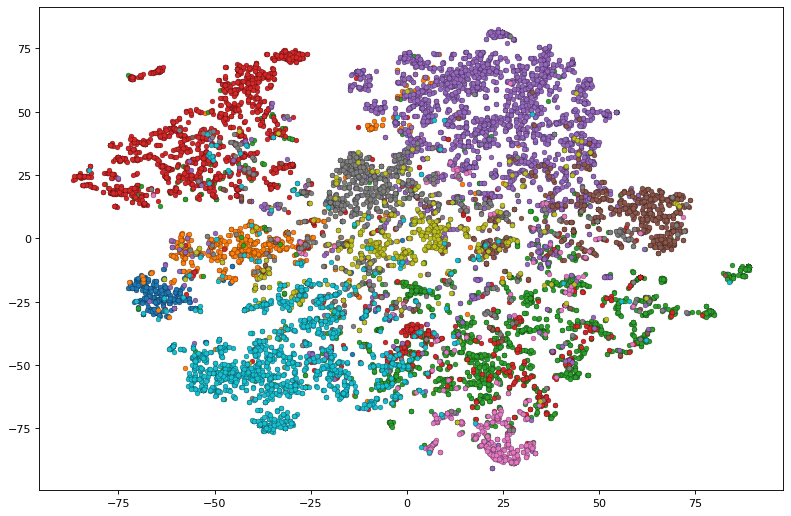

In [39]:
model_name=r'gat_000000.pth'  # This model is checked-in, feel free to use the one you trained
dataset_name=DatasetType.WIKICS.name


visualize_gat_properties(
        model_name,
        dataset_name,
        visualization_type=VisualizationType.EMBEDDINGS  # pick between attention, t-SNE embeddings and entropy
)